# Experiments for artificial dataset

In [1]:
import sys
import time

sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
from src import TrackMC

# Evaluation functions

In [4]:
def find_change(score, mode, *, threshold=0.01):
    """find change
    
    Args:
        score (np.ndarray): score
        mode (str): 'K' or 'MC'
    Returns:
        list: change points
    """
    change = []
    last_change = -100
    
    for t in range(9, 150):
        window_l = score[t - 9: t - 4]
        window_r = score[t - 4: t + 1]
        if t - last_change >= 5:
            if mode == 'K':
                if np.median(window_l) != np.median(window_r):
                    change.append(t)
                    last_change = t
            if mode == 'MC':
                if abs(np.median(window_l) - np.median(window_r)) > threshold:
                    change.append(t)
                    last_change = t
    
    return change

In [5]:
def delay(change):
    """delay
    
    Args:
        change (list): change points
    Returns:
        float: delay
    """
    change = np.array(change)
    
    change_valid = change[change >= 50]
    if len(change_valid) == 0:
        return 50
    else:
        return min(min(change_valid) - 49, 50)

In [6]:
def false_alarm_rate(change):
    """false alarm rate
    
    Args:
        change (list): change points
    Returns:
        float: FAR
    """
    allow = np.arange(50, 109)
    
    out_allow = [s not in allow for s in change]
    
    return sum(out_allow) / 91

# Move Gaussian dataset

## Create dataset

In [7]:
def move_gaussian_dataset(random_state):
    """
    Create move Gaussian dataset.
    
    Args:
        random_state (Optional[int]): random state.
    Returns:
        np.ndarray (shape=(150, 1000, 3)): move Gaussian dataset.
    """
    
    random = np.random.RandomState(seed=random_state)
    
    XX = []
    
    alpha = np.zeros(150)
    alpha[50: 100] = np.arange(50) * 6 / 50
    alpha[100:] = 6
    
    for t in range(150):
        
        X1 = random.randn(333, 3)
        X2 = random.randn(333, 3)
        X3 = random.randn(334, 3)
        
        X2[:, 0] += 10
        X3[:, 0] += 10 + alpha[t]
        
        XX.append(np.r_[X1, X2, X3])
        
    return XX

In [8]:
def plot_move_gaussian_dataset(t):
    """
    plot move gaussian dataset.
    
    Args:
        t (int): time.
        save_name (Optional[str]): file name to save.
    """
    # create data
    XX = move_gaussian_dataset(random_state=0)
    X = XX[t]
    
    # plot setting
    fig, ax = plt.subplots(figsize=(2.5, 1), dpi=200)
    ax.set_xlim(-5.0, 21.0)
    ax.set_ylim(-5.0, 5.0)
    for a in ['top', 'right', 'bottom', 'left']:
        ax.spines[a].set_linewidth(0.5)
    ax.tick_params(labeltop=False, labelright=False,
                   labelbottom=False, labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.98, right=0.98, bottom=0.02, left=0.02)
    
    # scatter X
    ax.scatter(X[:, 0], X[:, 1], color='red', s=1)
    
    plt.show()

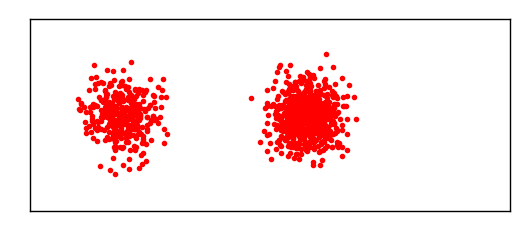

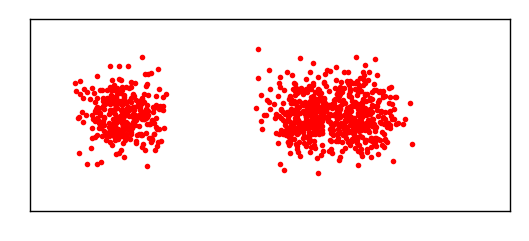

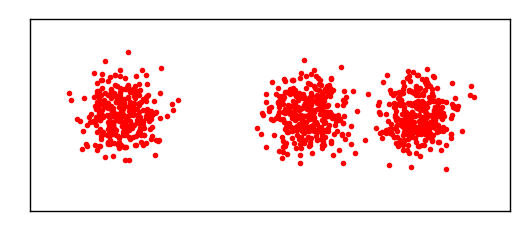

In [9]:
plot_move_gaussian_dataset(t=0)
plot_move_gaussian_dataset(t=74)
plot_move_gaussian_dataset(t=100)

## One trial

### t = 1 to 150

In [10]:
# data
XX = move_gaussian_dataset(0)

# calculate MC and K
track_mc = TrackMC(K_max=10, criterion='BIC', reg_covar=1e-3, random_state=0)
track_mc.fit(XX)
K_list = track_mc.K_list
mc_list = track_mc.mc_list(XX)

# change point
change_K = find_change(track_mc.K_list, 'K')
change_mc = find_change(track_mc.mc_list(XX), 'MC')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


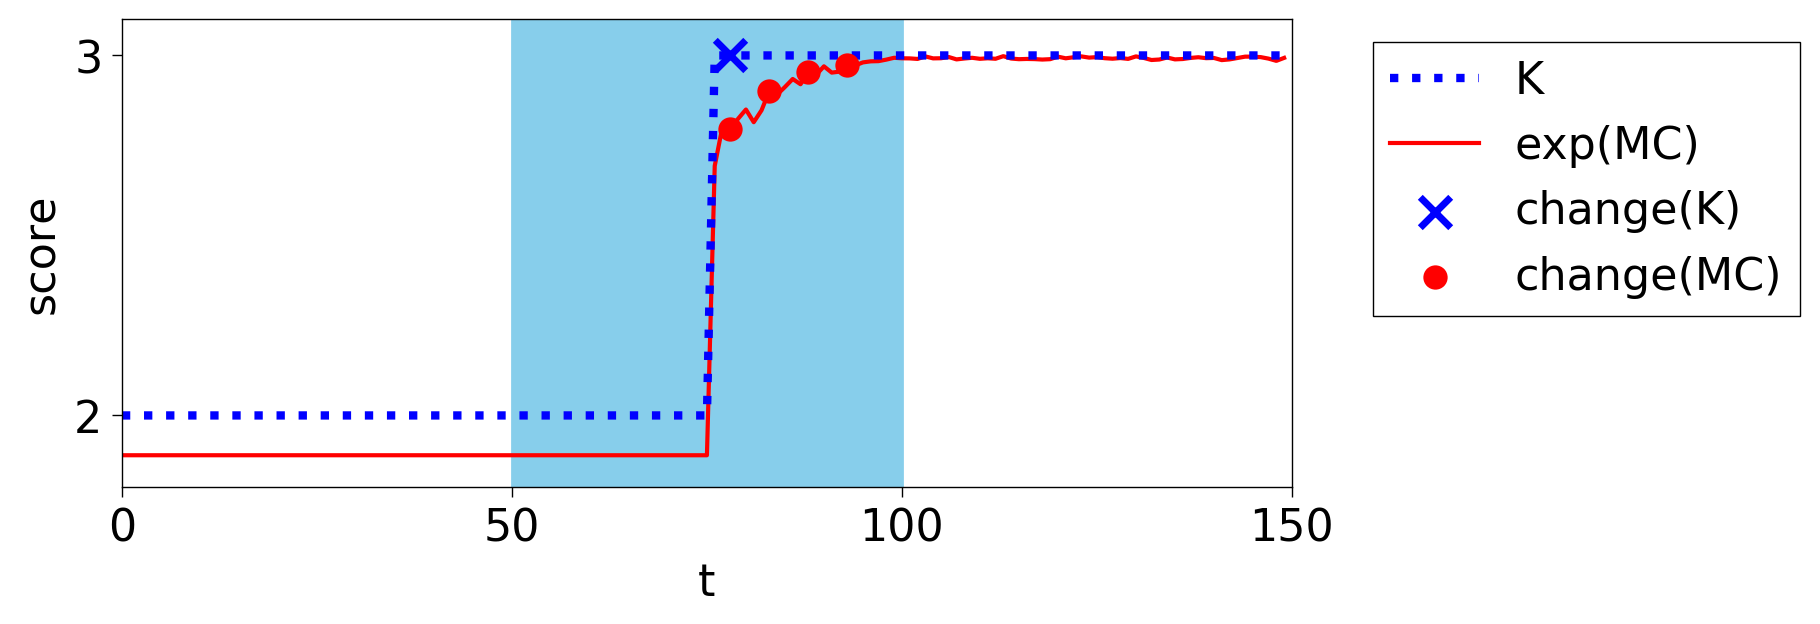

In [11]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 150)
ax.set_ylim(1.8, 3.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 50, 100, 150])
ax.set_yticks([2, 3])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(50, 101), 1.8, 3.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(150), K_list, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(150), np.exp(mc_list), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K, np.array(K_list)[change_K], color='blue', label='change(K)', s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc, np.exp(np.array(mc_list))[change_mc], color='red', label='change(MC)', s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

plt.show()

### t = 150 to 1

In [12]:
# data
XX = move_gaussian_dataset(0)[::-1]

# calculate MC and K
track_mc = TrackMC(K_max=10, criterion='BIC', reg_covar=1e-3, random_state=0)
track_mc.fit(XX)
K_list = track_mc.K_list
mc_list = track_mc.mc_list(XX)

# change point
change_K = find_change(track_mc.K_list, 'K')
change_mc = find_change(track_mc.mc_list(XX), 'MC')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.87it/s]


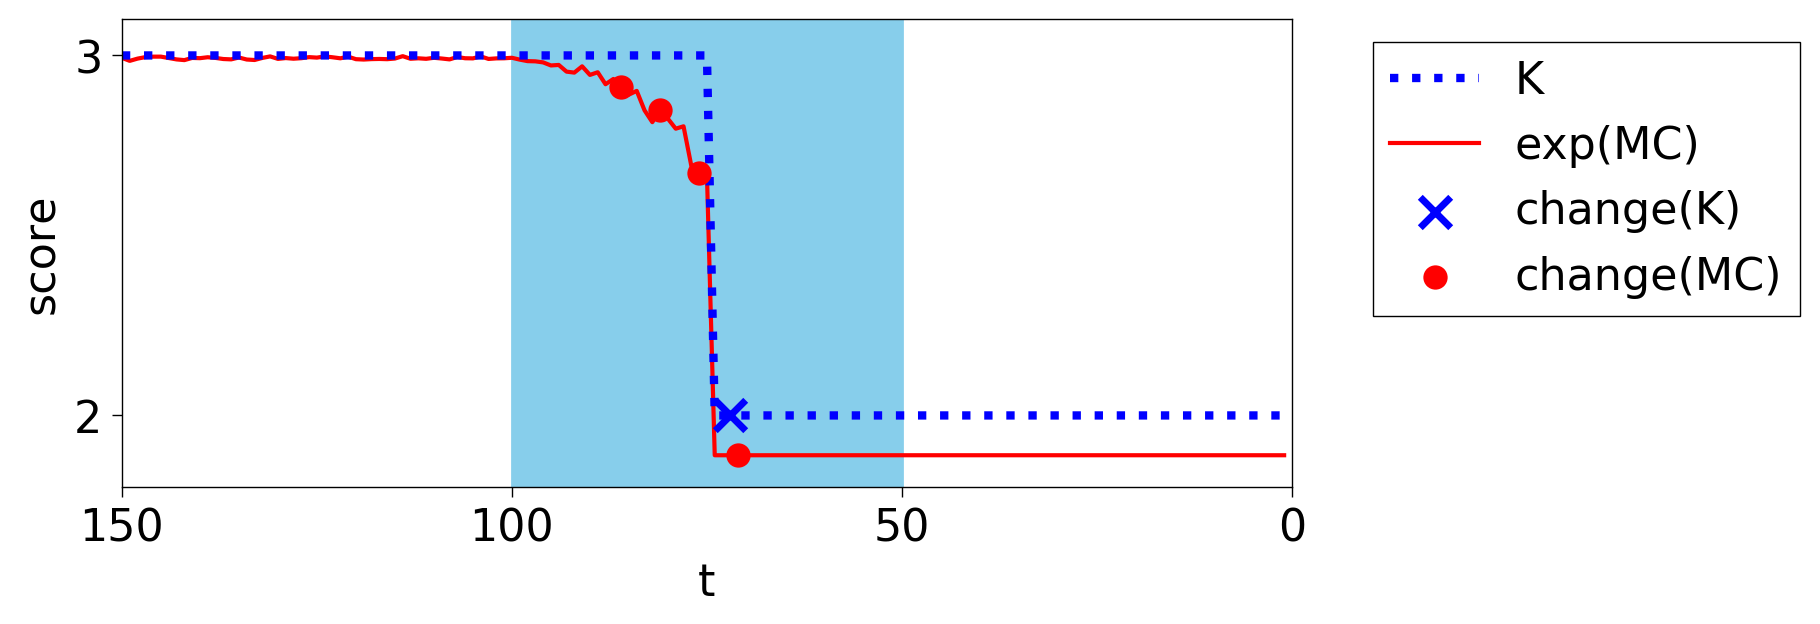

In [13]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 150)
ax.set_ylim(1.8, 3.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 50, 100, 150])
ax.set_xticklabels([150, 100, 50, 0])
ax.set_yticks([2, 3])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(50, 101), 1.8, 3.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(150), K_list, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(150), np.exp(mc_list), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K, np.array(K_list)[change_K], color='blue', label='change(K)', s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc, np.exp(np.array(mc_list))[change_mc], color='red', label='change(MC)', s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

plt.show()

# Imbalance Gaussian dataset

## Create dataset

In [14]:
def imbalance_gaussian_dataset(random_state):
    """
    Create move Gaussian dataset.
    
    Args:
        random_state (Optional[int]): random state.
    Returns:
        np.ndarray (shape=(150, 1000, 3)): move Gaussian dataset.
    """
    random = np.random.RandomState(seed=random_state)
    
    XX = []
    
    alpha = np.zeros(150, dtype=int)
    alpha[50: 100] = np.arange(50) * 5
    alpha[100:] = 250
    
    for t in range(150):
        
        X1 = random.randn(250, 3)
        X2 = random.randn(250, 3)
        X3 = random.randn(250 + alpha[t], 3)
        X4 = random.randn(250 - alpha[t], 3)
        
        X2[:, 0] += 10
        X3[:, 0] += 20
        X4[:, 0] += 30
        
        XX.append(np.r_[X1, X2, X3, X4])
        
    return XX

In [15]:
def plot_imbalance_gaussian_dataset(t):
    """
    plot imbalance gaussian dataset.
    
    Args:
        t (int): time.
        save_name (Optional[str]): file name to save.
    """
    # create data
    XX = imbalance_gaussian_dataset(random_state=0)
    X = XX[t]
    
    # plot setting
    fig, ax = plt.subplots(figsize=(2.5, 1), dpi=200)
    ax.set_xlim(-5.0, 35.0)
    ax.set_ylim(-5.0, 5.0)
    for a in ['top', 'right', 'bottom', 'left']:
        ax.spines[a].set_linewidth(0.5)
    ax.tick_params(labeltop=False, labelright=False,
                   labelbottom=False, labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.98, right=0.98, bottom=0.02, left=0.02)
    
    # scatter X
    ax.scatter(X[:, 0], X[:, 1], color='red', s=1)
    
    plt.show()

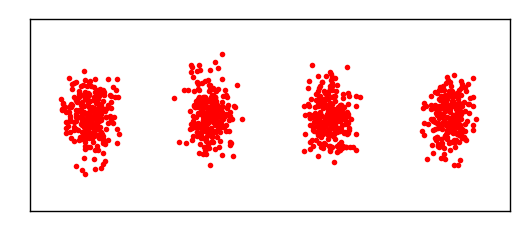

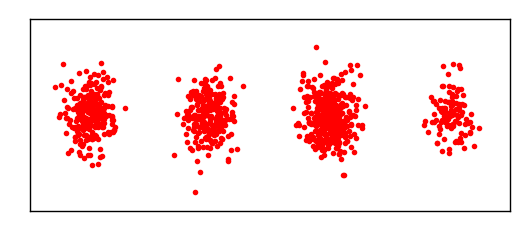

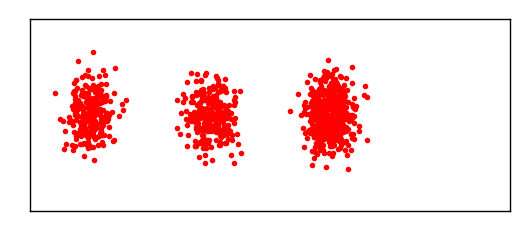

In [16]:
plot_imbalance_gaussian_dataset(t=0)
plot_imbalance_gaussian_dataset(t=79)
plot_imbalance_gaussian_dataset(t=100)

## One trial

### t = 1 to 150

In [17]:
# data
XX = imbalance_gaussian_dataset(0)

# calculate MC and K
track_mc = TrackMC(K_max=10, criterion='BIC', reg_covar=1e-3, random_state=0)
track_mc.fit(XX)
K_list = track_mc.K_list
mc_list = track_mc.mc_list(XX)

# change point
change_K = find_change(track_mc.K_list, 'K')
change_mc = find_change(track_mc.mc_list(XX), 'MC')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


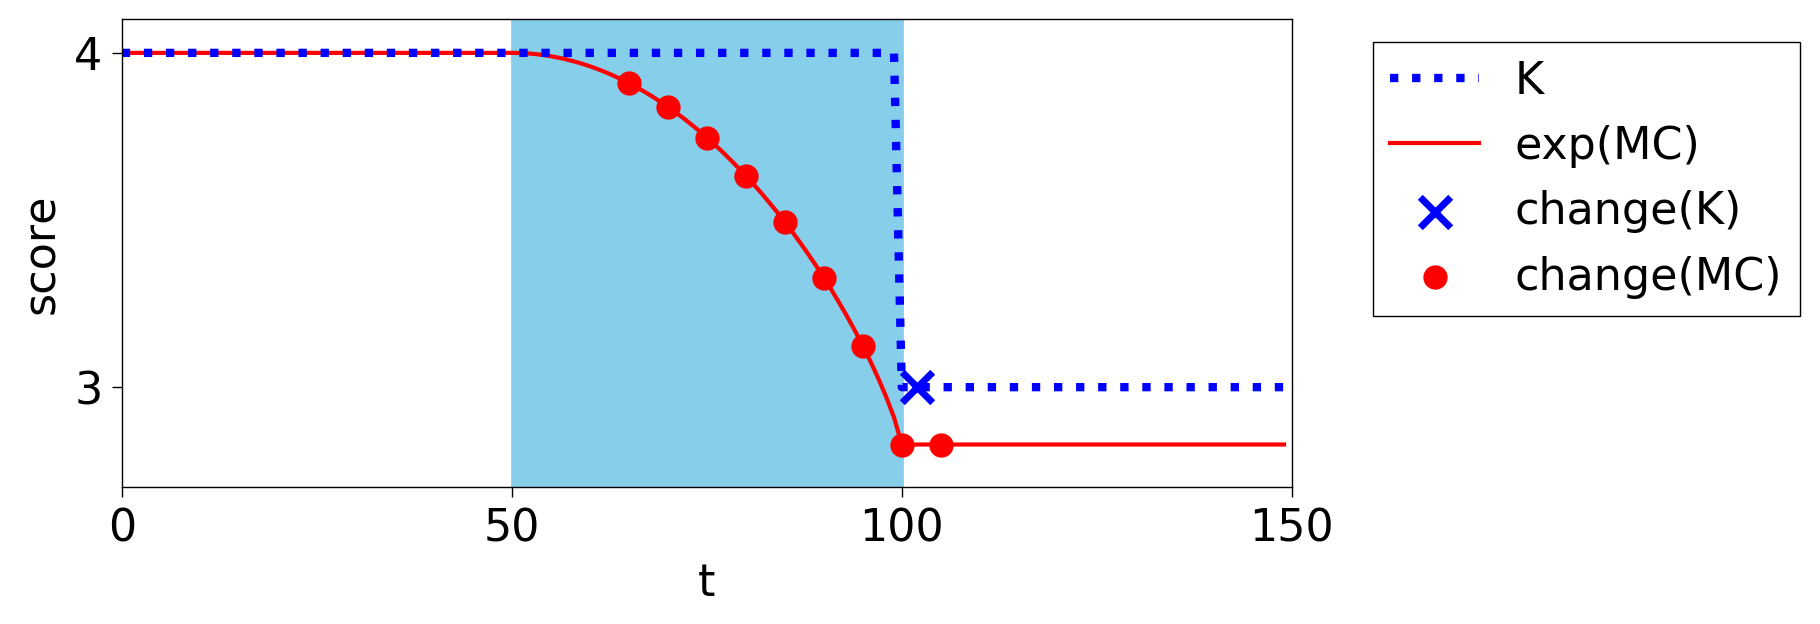

In [18]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 150)
ax.set_ylim(2.7, 4.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 50, 100, 150])
ax.set_yticks([3, 4])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(50, 101), 2.7, 4.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(150), K_list, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(150), np.exp(mc_list), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K, np.array(K_list)[change_K], color='blue', label='change(K)', s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc, np.exp(np.array(mc_list))[change_mc], color='red', label='change(MC)', s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

plt.show()

### t = 150 to 1

In [19]:
# data
XX = imbalance_gaussian_dataset(0)[::-1]

# calculate MC and K
track_mc = TrackMC(K_max=10, criterion='BIC', reg_covar=1e-3, random_state=0)
track_mc.fit(XX)
K_list = track_mc.K_list
mc_list = track_mc.mc_list(XX)

# change point
change_K = find_change(track_mc.K_list, 'K')
change_mc = find_change(track_mc.mc_list(XX), 'MC')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.52it/s]


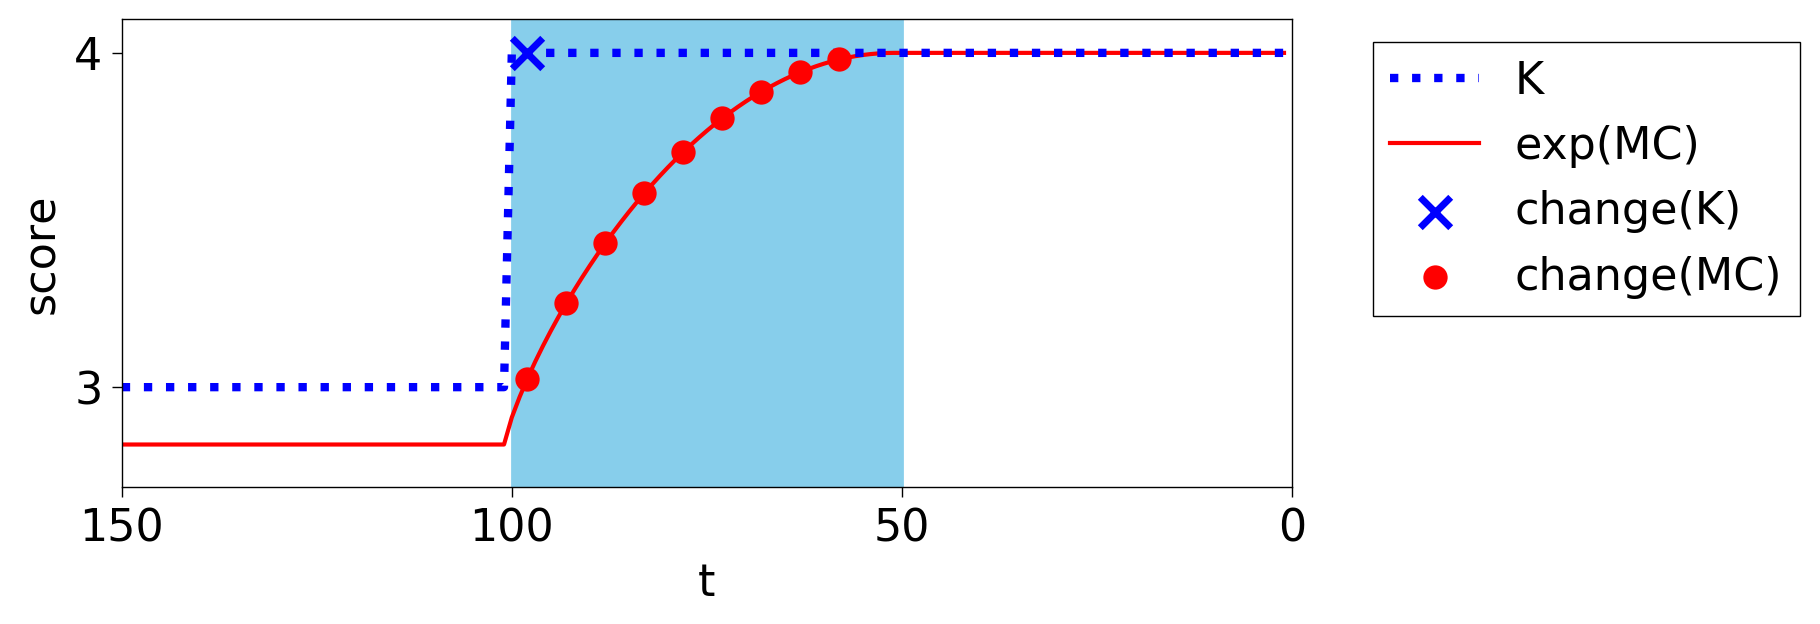

In [20]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 150)
ax.set_ylim(2.7, 4.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 50, 100, 150])
ax.set_xticklabels([150, 100, 50, 0])
ax.set_yticks([3, 4])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(50, 101), 2.7, 4.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(150), K_list, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(150), np.exp(mc_list), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K, np.array(K_list)[change_K], color='blue', label='change(K)', s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc, np.exp(np.array(mc_list))[change_mc], color='red', label='change(MC)', s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

plt.show()